# Import

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.preprocessing import sequence

import re
import os
import io
import time
import random

from sklearn.model_selection import train_test_split
from konlpy.tag import Mecab
from tqdm import tqdm
from tqdm import tqdm_notebook
import sentencepiece as spm
import seaborn # Attention 시각화를 위해 필요!

In [2]:
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

# Step 1. 데이터 다운로드

[jungyeul/korean-parallel-corpora](https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1)

In [3]:
path_to_file = os.getenv('HOME') + '/aiffel/s2s_translation/train/korean-english-park.train.ko'

with open(path_to_file, "r") as f:
    train_ko_raw = f.read().splitlines()

print("Data Size:", len(train_ko_raw))

print("Example:")
for sen in train_ko_raw[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


In [4]:
path_to_file = os.getenv('HOME')+'/aiffel/s2s_translation/train/korean-english-park.train.en'

with open(path_to_file, "r") as f:
    train_en_raw = f.read().splitlines()

print("Data Size:", len(train_en_raw))

print("Example:")
for sen in train_en_raw[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> Much of personal computing is about "can you top this?"
>> Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.
>> “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.
>> Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project.
>> Researchers also have debated whether weight-training has a big impact on the heart, since it does not give the heart and lungs the kind of workout they get from aerobic activities such as brisk walking or running for at least 20 minutes.


# Step 2. 데이터 정제 및 토큰화   
1) 중복을 제거한 데이터 : cleaned_corpus

In [5]:
cleaned_corpus = set(list(zip(train_ko_raw, train_en_raw)))

len(cleaned_corpus)

78968

2) 정제 함수 정의

In [6]:
def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip() #모든 입력을 소문자로 변환합니다. + 문장 앞뒤의 불필요한 공백을 제거합니다.
    sentence = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z?.!,1-9\\s]", "", sentence)#알파벳, 문장부호, 한글만 남기고 모두 제거합니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence) #문장부호 양옆에 공백을 추가합니다.
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    return sentence

In [7]:
kor_corpus = []
eng_corpus = []

for sentence in cleaned_corpus:
    en_sentence = preprocess_sentence(sentence[1])
    ko_sentence = preprocess_sentence(sentence[0])
    eng_corpus.append(en_sentence)
    kor_corpus.append(ko_sentence)

In [8]:
print(len(eng_corpus))
print(len(kor_corpus))

78968
78968


3) 한글 말뭉치 kor_corpus 와 영문 말뭉치 eng_corpus 를 각각 분리한 후, 정제하여 토큰화를 진행합니다!    
토큰화에는 Sentencepiece를 활용하세요. 첨부된 공식 사이트를 참고해 아래 조건을 만족하는 generate_tokenizer() 함수를 정의합니다.

In [9]:
with open('kor.txt', 'w') as f:
    for sentence in kor_corpus:
        f.write('{}\n'.format(sentence))

In [10]:
with open('eng.txt', 'w') as f:
    for sentence in eng_corpus:
        f.write('{}\n'.format(sentence))

In [11]:
#데이터 토큰화 
#https://donghwa-kim.github.io/SPM.html

def generate_tokenizer(txt):
    templates= '--input={} \
    --pad_id={} \
    --bos_id={} \
    --eos_id={} \
    --unk_id={} \
    --model_prefix={} \
    --vocab_size={} \
    --character_coverage={} \
    --model_type={}'
    
    train_input_file = txt
    pad_id=0  #<pad> token을 0으로 설정
    vocab_size = 2000 # vocab 사이즈
    prefix = 'botchan_spm' # 저장될 tokenizer 모델에 붙는 이름
    bos_id=1 #<start> token을 1으로 설정
    eos_id=2 #<end> token을 2으로 설정
    unk_id=3 #<unknown> token을 3으로 설정
    character_coverage = 1.0 # to reduce character set 
    model_type ='unigram' # Choose from unigram (default), bpe, char, or word

    cmd = templates.format(train_input_file,
                           pad_id,
                           bos_id,
                           eos_id,
                           unk_id,
                           prefix,
                           vocab_size,
                           character_coverage,
                           model_type)
    
    spm.SentencePieceTrainer.Train(cmd)
    sp = spm.SentencePieceProcessor()
    sp.Load(prefix + '.model')
    
    return sp

In [12]:
VOCAB_SIZE = 20000

ko_tokenizer = generate_tokenizer('kor.txt')
en_tokenizer = generate_tokenizer('eng.txt')
en_tokenizer.SetEncodeExtraOptions("bos:eos")

True

In [13]:
src_corpus = []
tgt_corpus = []

for i in range(0, len(cleaned_corpus)):
    src_tokens = ko_tokenizer.EncodeAsIds(kor_corpus[i])
    tgt_tokens = en_tokenizer.EncodeAsIds(eng_corpus[i])

    if (len(src_tokens) > 50): continue
    if (len(tgt_tokens) > 50): continue
    
    src_corpus.append(src_tokens)
    tgt_corpus.append(tgt_tokens)    

In [14]:
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

print(enc_train.shape)
print(dec_train.shape)
print(enc_train[0])

(42720, 50)
(42720, 50)
[  4  21 146  21   9   4 692  55  11  81 612  98 147  93  10 178 179 422
  12 462  46 187 193  24  61   9 136   4 734 174 369  54   6 135 843  37
   5   0   0   0   0   0   0   0   0   0   0   0   0   0]


In [15]:
with open('./kor_spm.vocab', encoding='utf-8') as f:
    Vo_k = [doc.strip().split("\t") for doc in f]

# w[0]: token name    
# w[1]: token score
kor_word2idx = {w[0]: i for i, w in enumerate(Vo_k)}

# Step 3. 훈련하기

In [16]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table

In [17]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

def generate_masks(inp, tar):
  # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

In [18]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        self.depth = d_model // self.num_heads

        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)

        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions


    def split_heads(self, x):
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x


    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)

        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)

        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)

        out = self.combine_heads(out)
        out = self.linear(out)

        return out, attention_weights

In [19]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

In [20]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual
        
        return out, enc_attn

In [21]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, causality_mask)
        out = self.do(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, padding_mask)
        out = self.do(out)
        out += residual

        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [22]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
    
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

In [23]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

In [24]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared_fc=True,
                    shared_emb=False):
        super(Transformer, self).__init__()

        self.d_model = tf.cast(d_model, tf.float32)

        if shared_emb:
            self.enc_emb = self.dec_emb = \
            tf.keras.layers.Embedding(src_vocab_size, d_model)
        else:
            self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared_fc = shared_fc

        if shared_fc:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]

        out = emb(x)

        if self.shared_fc: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out


    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)

        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)

        logits = self.fc(dec_out)

        return logits, enc_attns, dec_attns, dec_enc_attns

In [25]:
# Hyperparameters
N_LAYERS = 2
D_MODEL = 512
N_HEADS = 8
D_FF = 2048
DROPOUT = 0.3

transformer = Transformer(
    n_layers=N_LAYERS,
    d_model=D_MODEL,
    n_heads=N_HEADS,
    d_ff=D_FF,
    src_vocab_size=VOCAB_SIZE,
    tgt_vocab_size=VOCAB_SIZE,
    pos_len=200,
    dropout=DROPOUT,
    shared_fc=True,
    shared_emb=True)

d_model = 512

In [26]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()

        self.d_model = d_model
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)

        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

In [27]:
learning_rate = LearningRateScheduler(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)
type(optimizer)

tensorflow.python.keras.optimizer_v2.adam.Adam

In [28]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [29]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]
    gold = tgt[:, 1:]

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

In [30]:
def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)

    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()

    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [31]:
def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')

    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [32]:
def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

# 모델 학습

In [33]:
sentences = ['오바마는 대통령이다.', '시민들은 도시 속에 산다.', '커피는 필요 없다.', '일곱 명의 사망자가 발생했다.']

In [35]:
BATCH_SIZE = 64
EPOCHS = 15

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer, optimizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    for sentence in sentences:
        translate(sentence, transformer, ko_tokenizer, en_tokenizer)

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':



Input: 오바마는 대통령이다.
Predicted translation: obama is obamas .
Input: 시민들은 도시 속에 산다.
Predicted translation: the suns , the sliests are sing .
Input: 커피는 필요 없다.
Predicted translation: it is not to get to get a , but it is not .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the deaths were killed .



Input: 오바마는 대통령이다.
Predicted translation: obama is a very , the presidential nominee .
Input: 시민들은 도시 속에 산다.
Predicted translation: they have been enough to be suffed .
Input: 커피는 필요 없다.
Predicted translation: we need to be a friend .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the deaths death was killed .



Input: 오바마는 대통령이다.
Predicted translation: obama is the symbol .
Input: 시민들은 도시 속에 산다.
Predicted translation: the citys are also strucks .
Input: 커피는 필요 없다.
Predicted translation: theres no needs to need to need to be needed .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the deaths death toll from the deaths .



Input: 오바마는 대통령이다.
Predicted translation: obama is a gravated .
Input: 시민들은 도시 속에 산다.
Predicted translation: the slightly slightly slightly .
Input: 커피는 필요 없다.
Predicted translation: the customers need to be needed .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the estimates of thousands of deaths were dead .



Input: 오바마는 대통령이다.
Predicted translation: obama is the first to the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens are also promised to drop to a fire .
Input: 커피는 필요 없다.
Predicted translation: no longer doesnt need to be .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the dead were killed .



Input: 오바마는 대통령이다.
Predicted translation: obama is a baldel , the address is the issue .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens in the city of yellow seas .
Input: 커피는 필요 없다.
Predicted translation: theres no needs .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the dead were killed .



Input: 오바마는 대통령이다.
Predicted translation: obama is a graced , obama is a sensitive .
Input: 시민들은 도시 속에 산다.
Predicted translation: the citys are now known for the democracy .
Input: 커피는 필요 없다.
Predicted translation: theres no need of a couple need to be needed .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died in the disaster .



Input: 오바마는 대통령이다.
Predicted translation: obama is a grant , a later a year .
Input: 시민들은 도시 속에 산다.
Predicted translation: people also have been speed in towns .
Input: 커피는 필요 없다.
Predicted translation: dont need to be eliminate .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other deaths were reported killed .



Input: 오바마는 대통령이다.
Predicted translation: obama is a baby .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens in the city .
Input: 커피는 필요 없다.
Predicted translation: we need little .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven deaths were reported killed .



Input: 오바마는 대통령이다.
Predicted translation: obama is a rebuilding this week .
Input: 시민들은 도시 속에 산다.
Predicted translation: the peoples also have been pushing for asylo to syd .
Input: 커피는 필요 없다.
Predicted translation: no matter . need it is necessary .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people have been able to death .



Input: 오바마는 대통령이다.
Predicted translation: obama is a sitting , or takes for the .
Input: 시민들은 도시 속에 산다.
Predicted translation: citys also quickly expanded by a tra mountainep in town near town .
Input: 커피는 필요 없다.
Predicted translation: hacker speer doesnt go .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: six victims have been death sunday in the blast , the associated press reported .



Input: 오바마는 대통령이다.
Predicted translation: obama is a tos almali is a distlear
Input: 시민들은 도시 속에 산다.
Predicted translation: the docks continue to eminate .
Input: 커피는 필요 없다.
Predicted translation: parker needs .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died .



Input: 오바마는 대통령이다.
Predicted translation: obama is a reselling body .
Input: 시민들은 도시 속에 산다.
Predicted translation: people in town for citizens in town .
Input: 커피는 필요 없다.
Predicted translation: i need to no speer .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: six more deaths were killed .



Input: 오바마는 대통령이다.
Predicted translation: obama is a revers
Input: 시민들은 도시 속에 산다.
Predicted translation: people are living in town .
Input: 커피는 필요 없다.
Predicted translation: i cannot need to no speee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: six victims were killed .



Input: 오바마는 대통령이다.
Predicted translation: obama is a is a may .
Input: 시민들은 도시 속에 산다.
Predicted translation: city officials said they land in abandoning a mountain .
Input: 커피는 필요 없다.
Predicted translation: hack coffeee is a need for way .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: there are deaths excuse toll to boost the piet .


Input: 오바마는 대통령이다.
Predicted translation: obama is a is a may .
Encoder Layer 1


/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0, flags=flags)


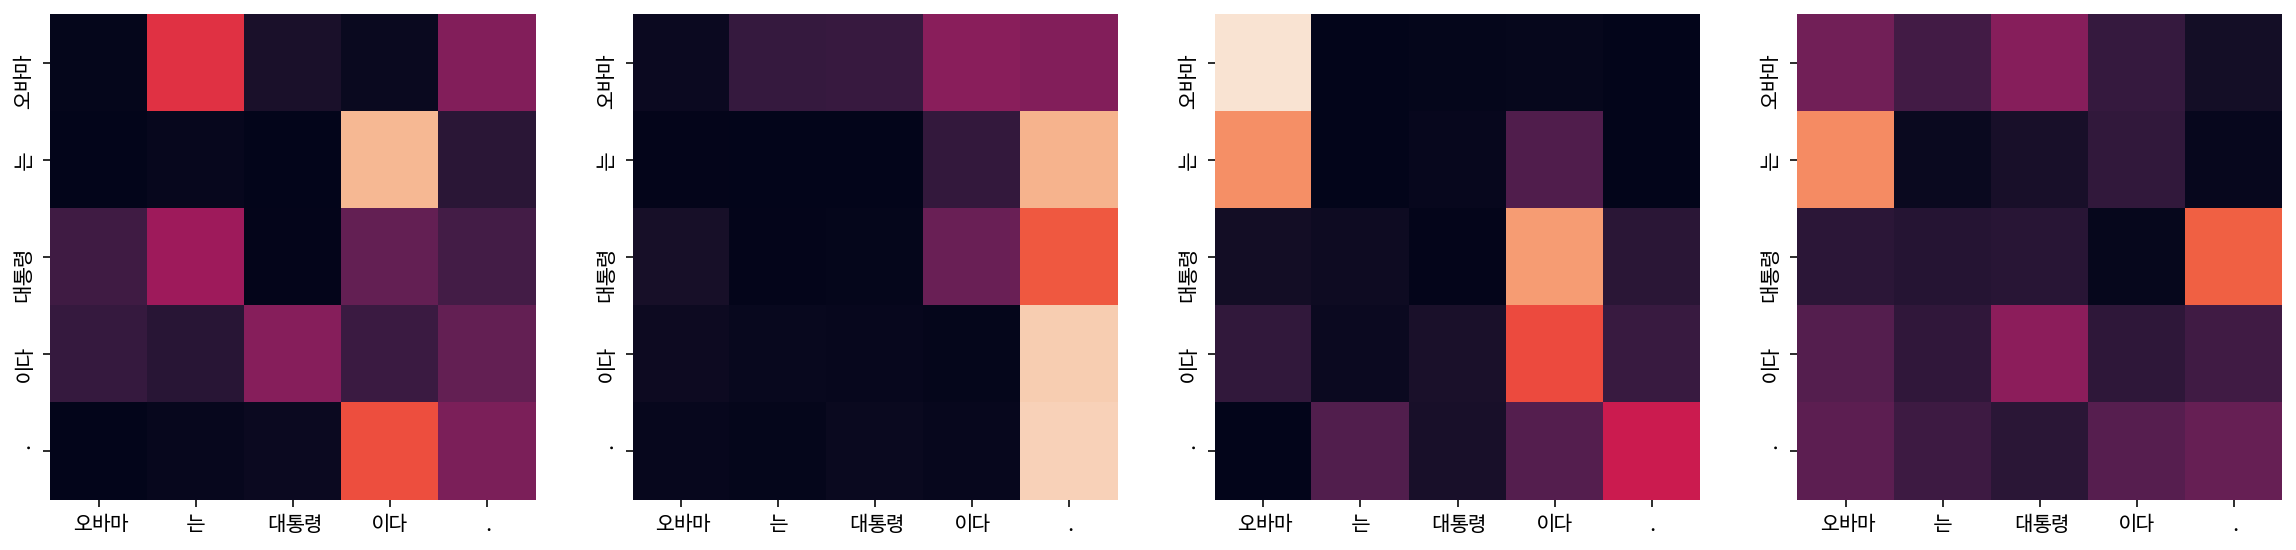

Encoder Layer 2


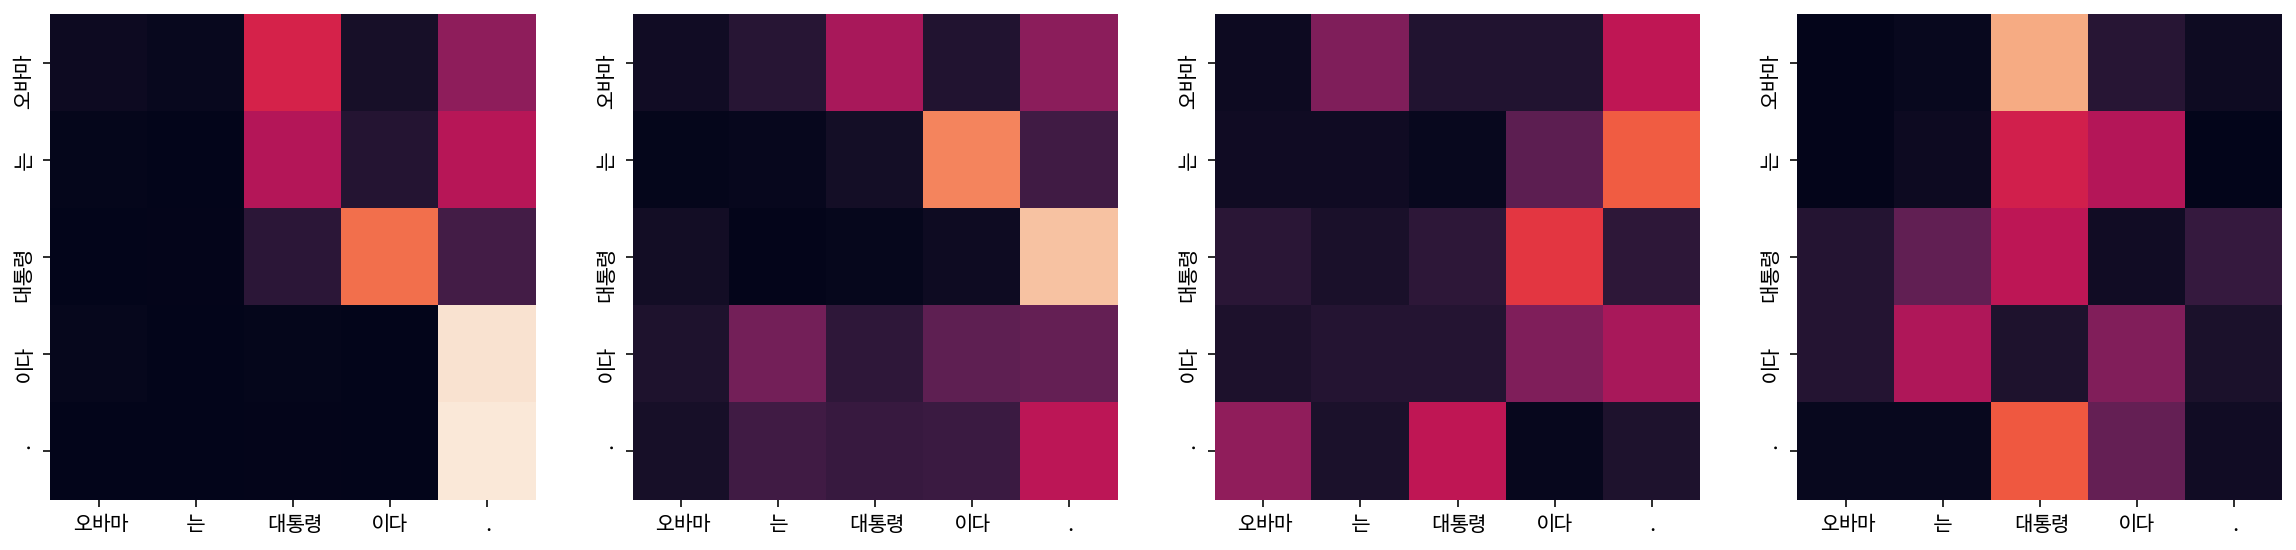

Decoder Self Layer 1


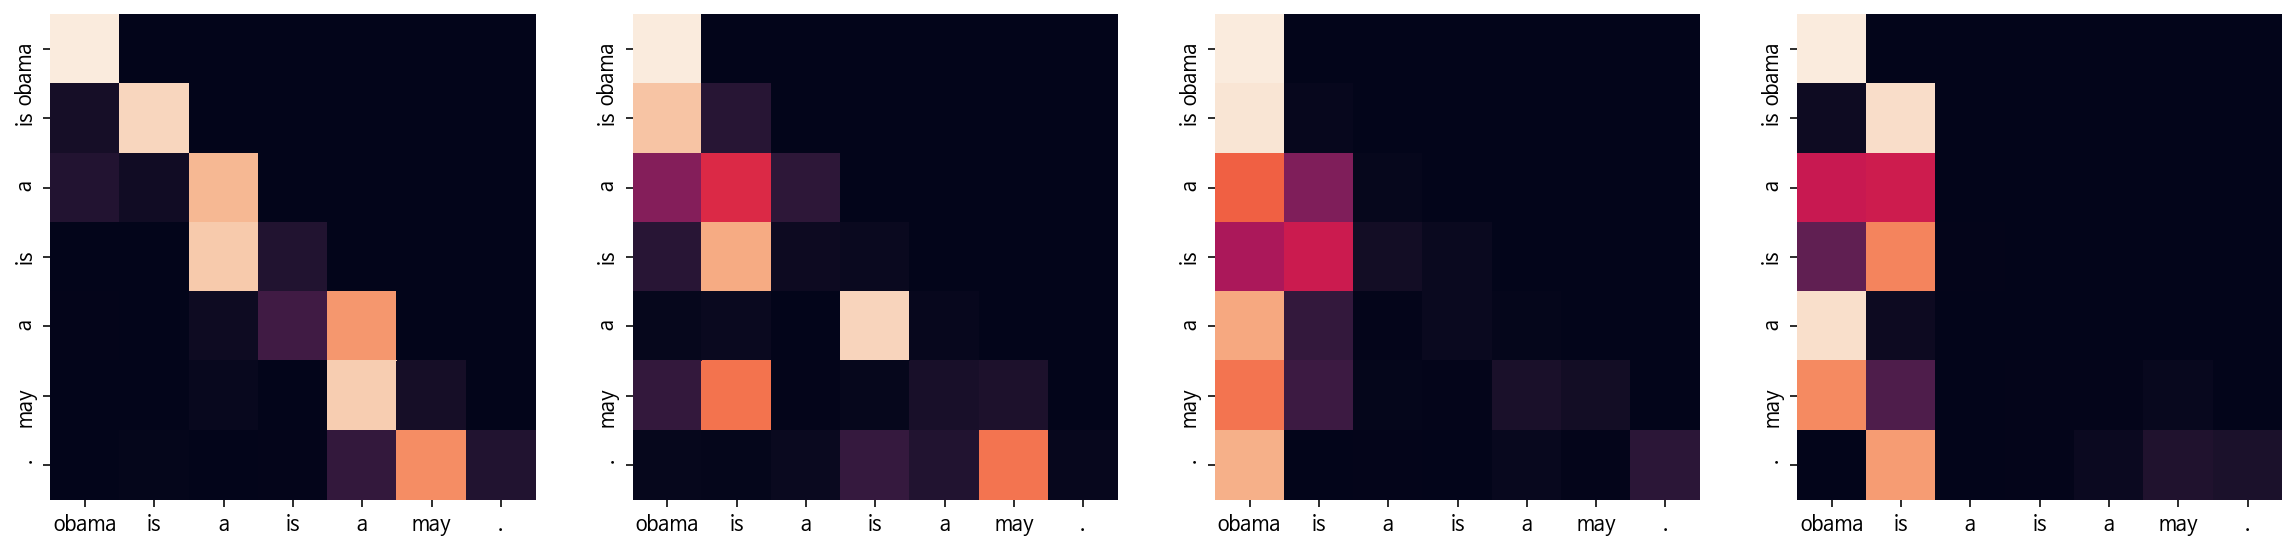

Decoder Src Layer 1


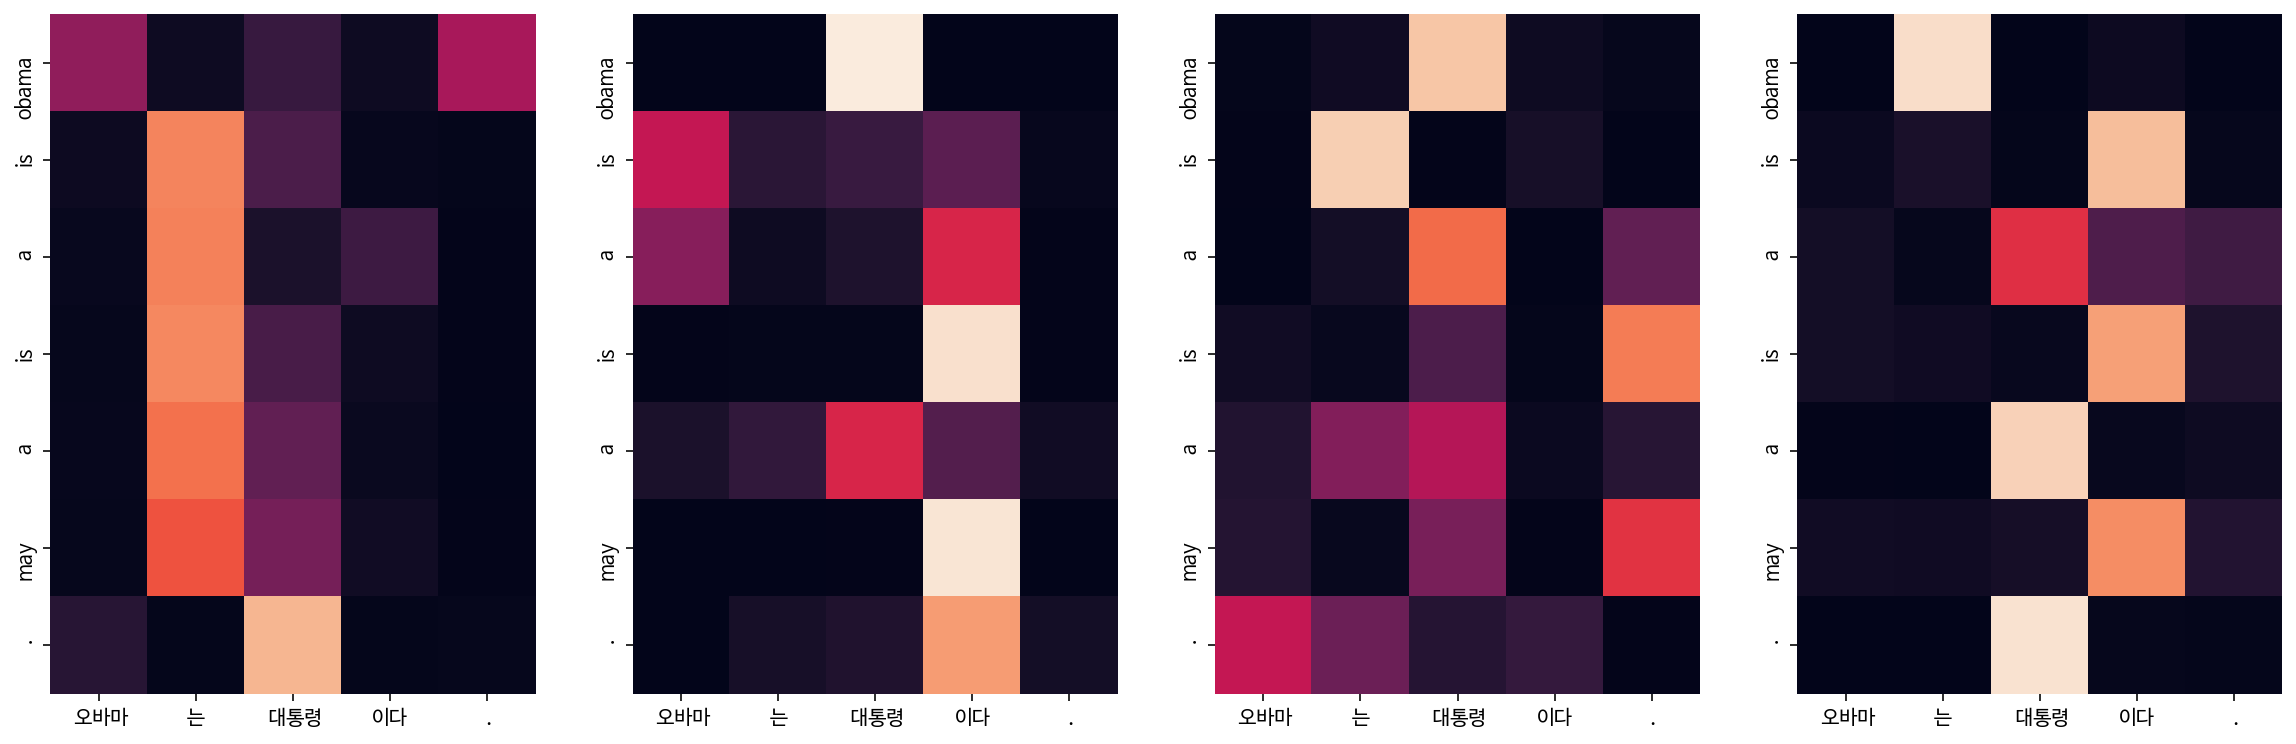

Decoder Self Layer 2


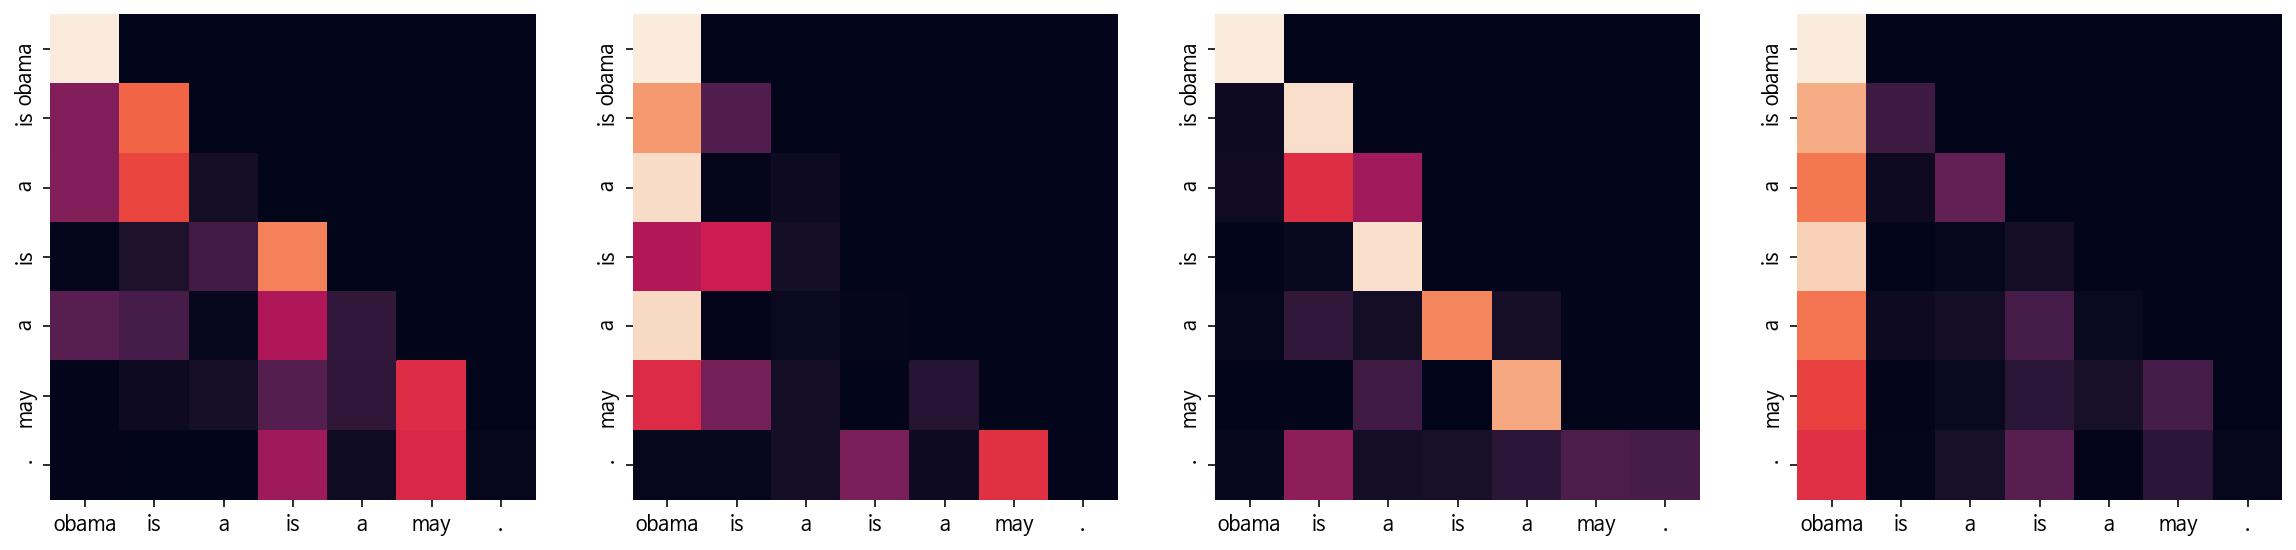

Decoder Src Layer 2


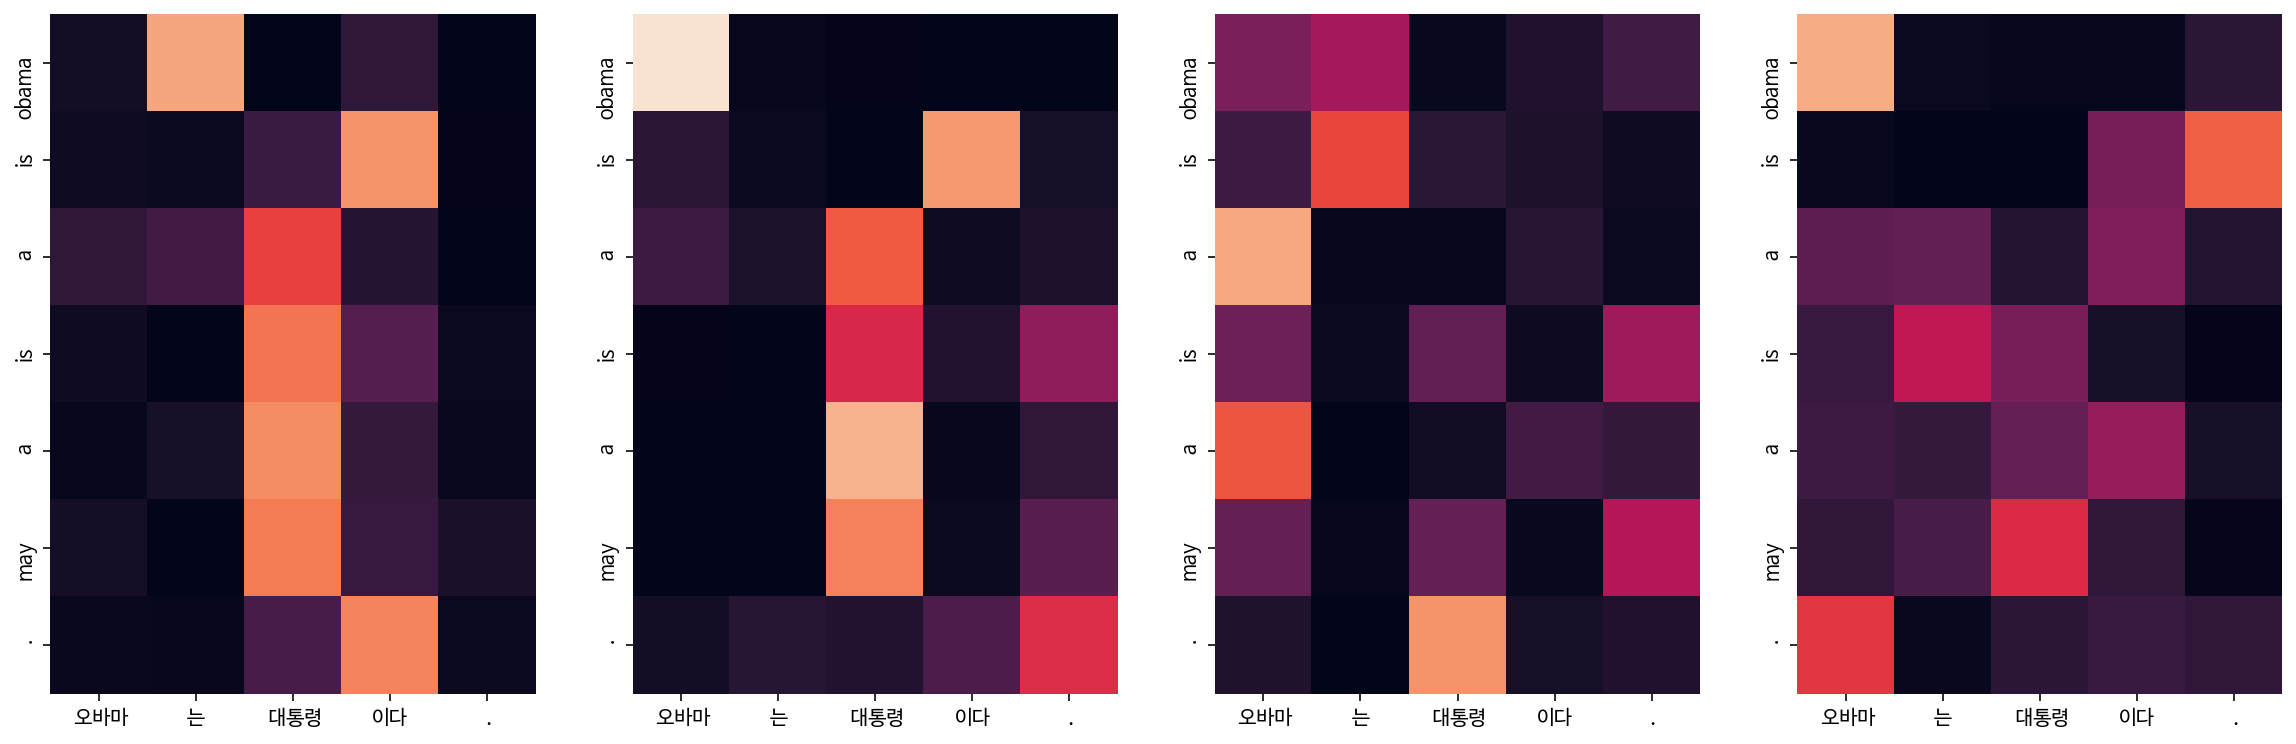

In [36]:
translate('오바마는 대통령이다.',transformer, ko_tokenizer, en_tokenizer, plot_attention = True)

# 총평

seq2seq에 비해 성능적으로 월등한 transformer 기법이 왜 자연어처리를 휩쓸었는지 알 수 있었다.   
